In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from os import listdir

In [2]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [3]:
sns.set_context('talk')

In [4]:
cd O:\TUD\__eDICE-paper\__for-paper\data_publication\FRAP_dumbbells

O:\TUD\__eDICE-paper\__for-paper\data_publication\FRAP_dumbbells


Load data

In [5]:
# where to find the data
thefilepath = r'O:\TUD\__eDICE-paper\__for-paper\data_publication\FRAP_dumbbells'

# find files containing the membrane profiles
files = find_csv_filenames( thefilepath )

# initialize dataframe
df = pd.DataFrame(columns=['distance (um)', 'grey value', 'grey rolling', 'frame', 'measurement', 'step'])

# iterate over frames
for fileno in range(len(files)): 
    file = files[fileno]
    tempdf = pd.read_csv(thefilepath+'\\'+files[fileno], skiprows=[0], names = ['distance (um)', 'grey value'])
    tempdf['grey rolling'] = tempdf['grey value'].rolling(9).mean()
    tempdf['measurement']=files[0].split('_')[0]
    tempdf['relative x']=tempdf['distance (um)']/tempdf['distance (um)'].max()
    tempdf['frame']=int(files[fileno].split('_')[-1].split('.')[0])
    
    # associate metadata
    if '_bleach_' in files[fileno]:
        tempdf['step']=len(tempdf)*['bleach']
    elif '_pre_' in files[fileno]:
        tempdf['step']=len(tempdf)*['pre-bleach']
    elif '_PB' in files[fileno]:
        tempdf['step']=len(tempdf)*['post-bleach']
    
    # collect in one dataframe
    df = pd.concat([df, tempdf])
    
# clean up data by removing duplicate indices
df.reset_index(inplace=True, drop=True)

Plot example profiles: just before bleaching, just after bleaching, at the end of the recovery period

<AxesSubplot:xlabel='relative x', ylabel='grey rolling'>

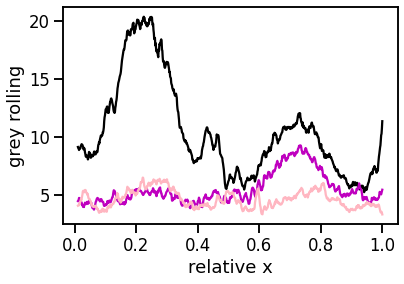

In [6]:
sns.lineplot(data=df.loc[(df['step']=='pre-bleach') & (df['frame']==-1)], 
             x='relative x', y='grey rolling', 
             color='k')#, hue='frame')
sns.lineplot(data=df.loc[(df['step']=='post-bleach') & (df['frame']==1)], 
             x='relative x', y='grey rolling', 
             color='m')#, hue='frame')
sns.lineplot(data=df.loc[(df['step']=='post-bleach') & (df['frame']==10)], 
             x='relative x', y='grey rolling', 
             color='lightpink')#, hue='frame')

Add metadata (measured in Fiji): how long is the bright lobe outline, how long the dim lobe outline?

In [7]:
length_bright = 11.735
length_dim = 13.088

# calculate where the profiles switch between the lobes
border_x = length_bright/(length_bright + length_dim)
border_x

0.47274704910768234

Add metadata (from image metadata): image height and with and pixel dwell time

In [8]:
frame_height = 512
frame_width = 512
px_dwelltime = 0.95 * 10**(-6)
time_per_frame = frame_height* frame_width * px_dwelltime

Calculate recovery curves

In [9]:
df_comp = pd.DataFrame()
df_comp['frame']=df.groupby('frame').mean().reset_index()['frame']
# calculate mean intensity and SD for bright lobe for each frame
df_comp['bright mean']=df.loc[df['relative x']<border_x].groupby('frame').mean().reset_index()['grey value']
df_comp['bright sd']=df.loc[df['relative x']<border_x].groupby('frame').std().reset_index()['grey value']
# calculate mean intensity and SD for bright lobe for each frame
df_comp['dim mean']=df.loc[df['relative x']>border_x].groupby('frame').mean().reset_index()['grey value']
df_comp['dim sd']=df.loc[df['relative x']>border_x].groupby('frame').std().reset_index()['grey value']
# calculate ratio of bright and dim per frame
df_comp['ratio']=df_comp['bright mean']/df_comp['dim mean']
df_comp['ratio sd']=df_comp['bright sd']*df_comp['ratio']/df_comp['bright mean']
# calculate time in seconds
df_comp['time (s)'] = df_comp['frame']*time_per_frame

Plot recovery curves

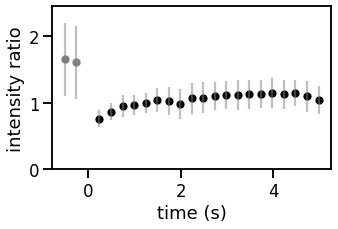

In [10]:
f = plt.figure(figsize=[5, 3])

# error bars
err_x = df_comp.groupby('time (s)').mean().reset_index()['time (s)']
err_y = df_comp.groupby('time (s)').mean()['ratio']
err_b = df_comp.groupby('time (s)').mean()['ratio sd']
plt.errorbar(err_x, err_y, err_b, color='grey', ls='none', alpha=0.5)

# data points
ax = sns.scatterplot(data=df_comp, x='time (s)', y='ratio', color='k')
sns.scatterplot(data=df_comp.loc[df_comp['frame']<0], 
                x='time (s)', y='ratio', 
                color='grey')

# make plot pretty
ax.set_ylim(0,2.45)
ax.set_ylabel('intensity ratio')

# save plot
fig = ax.get_figure()
fig.savefig('FRAP030_dumbbell_ratio-recovery.png', dpi=300, bbox_inches='tight')